
# Model eigenvalues  

Eigenvalues are a fundamental concept in dynamic models. In simple terms, they summarize the adjustment process within a model. In the context of dynamic models, the sign and magnitude of the eigenvalues determine whether a system of equations will converge to a stable equilibrium, oscillate, or diverge. 

In the case of a macromodel, which is effectively a system of differential equations, the eigenvalues of the coefficient matrix determine whether the system is stable, marginally stable, or unstable. If all the eigenvalues have negative real parts, then the system is stable and will converge to a steady state over time. If at least one eigenvalue has a positive real part, then the system is unstable, and the solutions will diverge over time.


The modelflow library includes a range of methods to calculate the eigenvalues of a model, which can be used to help to assure that a model's dynamics will be stable and to identify sources of instability where they exist.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [3]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In [4]:
# Import to handle imaginary numbers 
import numpy as np 

# Import of modelflow lineraization methods. 
from modelnewton import newton_diff

## Load a pre-existing model, data and descriptions 

For the purposes of this exposition the climate aware model forPakistan described {cite:author}`burns_climate_2021` is used.



In [5]:
mpak,baseline = model.modelload('../models/pak.pcim')
baseline = mpak(baseline,2023,2024)


file read:  C:\mflow\papers\mfbook\content\models\pak.pcim


:::{index} single: modelflow; .newtondiff() method
:::

:::{index} single: model derivatives
:::

:::{index} single: eigenvalues
:::

:::{index} single: modelflow; eigenvalues
:::
## the method .newton_diff()

The `modelflow` method `.newtondiff()` calculates the derivatives of the mpak model, and in the code block belows assigne the results to the object mpak_newton.


In [6]:
mpak_newton = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives 

:::{index} single: eigenvalyues; .get_eigenvalues() method
:::
:::{index} single: modelflow; .get_eigenvalues() method
:::

### .get_eigenvalues method
The get_eigenvectors function calculates the actual eigenvectors of the model.  For a large model this can be a fairly time consuming calculation taking several minutes even on relatively powerful multicore i9 computers.

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::
Once the eigenvalues are calculated they can be displayed graphically with the `.eigplot_all()` method.

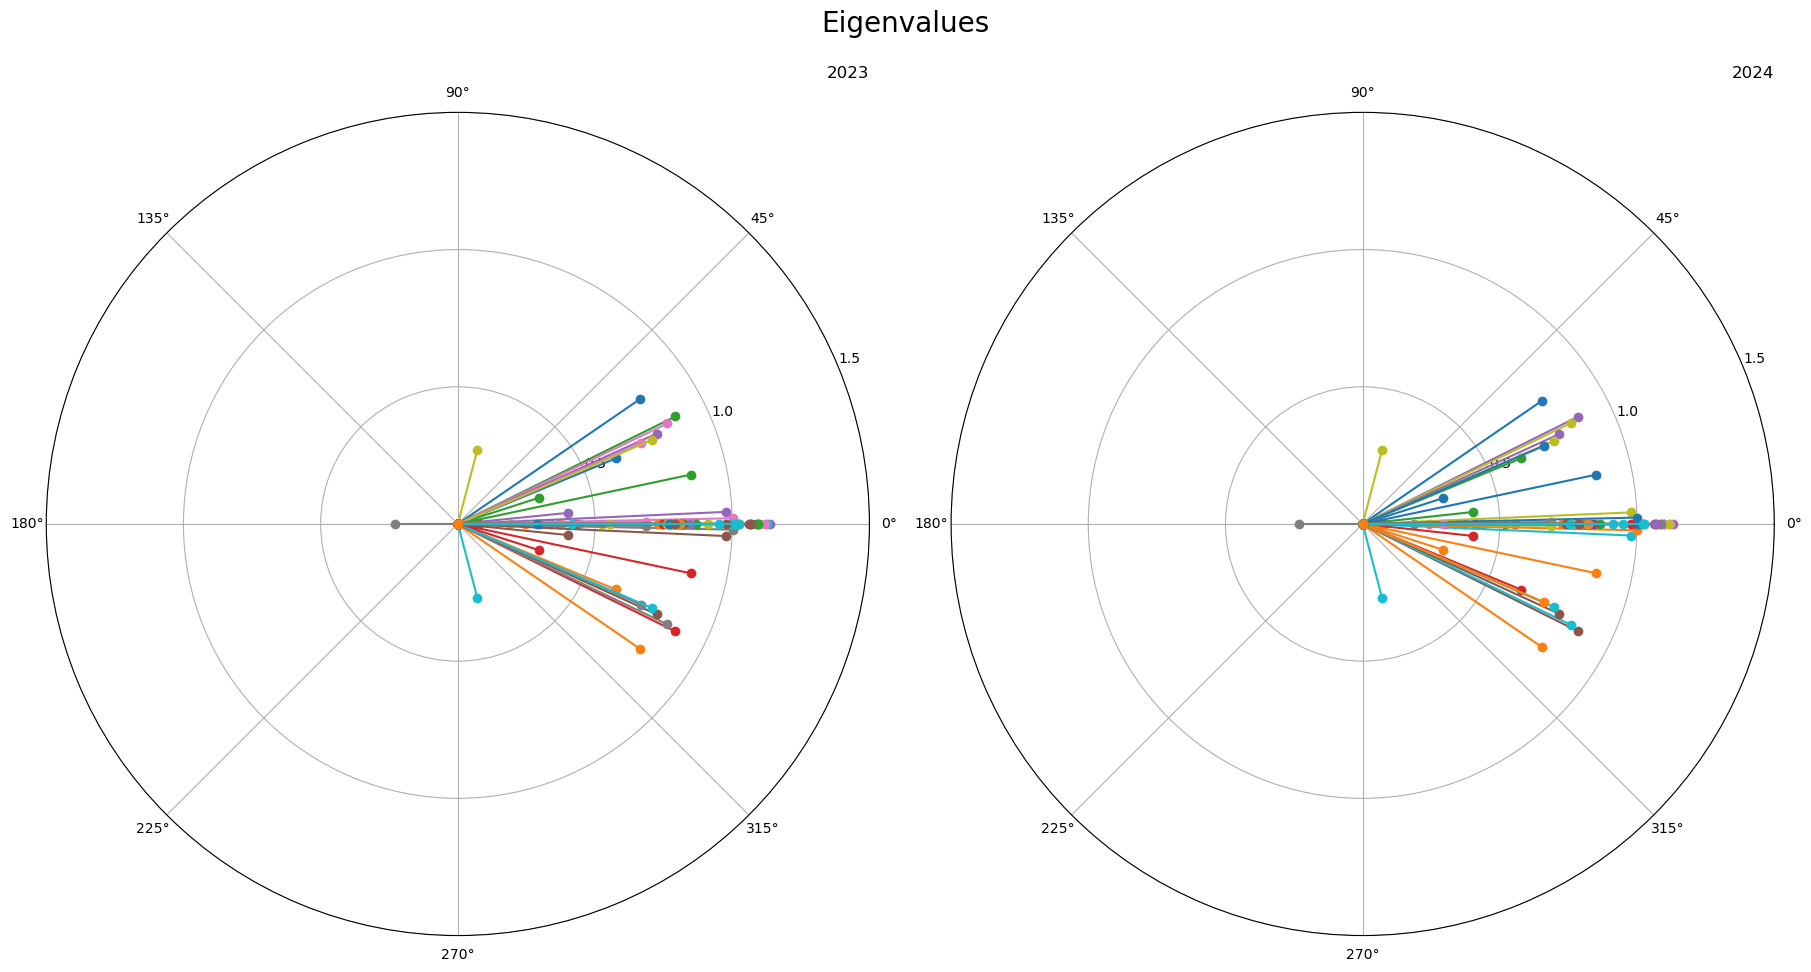

In [7]:
eig_dic = mpak_newton.get_eigenvectors(filnan = True,periode= (2023,2024),silent=False,asdf=1) #  
mpak_newton.eigplot_all(eig_dic,size=(3,3));

### Isolating potentially problematic eigenvalues

In the charts above it is clear that the vast majority of eigenvalues lie within the real unit circle, implying that the associated equations are dynamically stable.  However, there are several that lie outside of the unit circle.

The code below identifies and prints out those elements that are greater than one.

In [8]:
eigen = eig_dic[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True)
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True)

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii} length: {abs(i):.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii} length: {abs(i):.5f} {i.real:.5f} {i.imag:.5f}' for ii,i in gt1_imag],sep='\n')



Eigenvalues with length above 1 and only real: 
element 1499 length: 1.02441 
element 1419 length: 1.02000 
element 1325 length: 1.06952 
element 1324 length: 1.06998 
element 1323 length: 1.06368 
element 1322 length: 1.08554 
element 1321 length: 1.00287 
element 1320 length: 1.06036 
element 1312 length: 1.09349 
element 1306 length: 1.12010 
element 1289 length: 1.12521 
element 535 length: 1.00816 
element 495 length: 1.02299 
element 494 length: 1.13663 
element 456 length: 1.09513 
element 455 length: 1.09868 
  
Eigenvalues with length above 1 and imaginary: 
element 1317 length: 1.00303 1.00282 -0.02085
element 1316 length: 1.00303 1.00282 0.02085


These results that 16 eigenvalues exceed 1 and that two exceed one and have imaginary roots.

## Dealing with potential instability

Unfortunately there is no one-to-one relationship between equations and eigenvalues. 

It may be that certain equations are inherently unstable: for example, error-correction models where the speed of adjustment is greater than one.  Equation results can be inspected for such sources of instability.  

Other sources of instability may be more subtle and lie in the interaction of coefficients across equations.  One approach to identifying potentially problematic equations is to perform a grid-search by recalculating the eigenvalues of the system after excluding individual equations one at a time. The elimination of an ill-formed equation is likely to cause large and greater than one eigenvalues to shrink and potentially even fall within the unit circle.

:::{index} single: stability; .get_eigen_jackknife_abs_select() method
:::
:::{index} single: eigenvalues; .get_eigen_jackknife_abs_select() method
:::
:::{index} single: modelflow; .get_eigen_jackknife_abs_select() method
:::


### The `.get_eigen_jackknife_df()` method

Modelflow includes a jackknife algorithm (`.get_eigen_jackknife_df()`) that goes through the model and systematically drops each equation from the model, and then recalculates the eigenvalues of the smaller model, it then re-inserts the previously dropped equation and drops the next equation until the eigenvalues have been calculated as many times as their are equations. With each simulation it also calculates the sum of the xx largest addfactors.

For a large model, this can be a time-consuming exercise.


The returned dataframe is comprised of the following columns:

| Column     | Explanation                                         |
|:-----------|:-----------------------------------------------------|
| excluded   | The name or identifier of the excluded variable.    |
| year       | The year associated with the data row.              |
| index      | The index or position of the row in the dataset.    |
| value      | The computed or observed value for the row.         |
| length     | The absolute length or magnitude of the `value`.    |
| realvalue  | The real part of the `value` if it's complex.       |
| imagvalue  | The imaginary part of the `value` if it's complex.  |



For a large model, this can be a time-consuming exercise (7-12 minutes for mpak, depending on the user's processor). 

In the example below `.get_eigen_jackknife_abs_select()` is called for the year 2023, and with the parameters `maxnames=500`, which limits the number of equations that will be tested to 500, and `largest=40`, which causes the method to return a dataframe comprised of the sum of the eigenvalues of  largest 20 eigenvalues.

To test code, the parameter maxnames can be set to restrict the number of re-samplings.

The routine sums the 20 largest eigenvalues each time an equation is omitted.  Equations whose omission from the model reduces the largest eigenvalues the most are most likely to be the source of model instability.


In [9]:
mpak_newton.get_eigen_jackknife_df.cache_clear()

AttributeError: 'newton_diff' object has no attribute 'get_eigen_jackknife_df'

In [10]:
jackdf  = mpak_newton.get_eigen_jackknife_df()

AttributeError: 'newton_diff' object has no attribute 'get_eigen_jackknife_df'

In [ ]:
jackdf.head()

In [ ]:
jackdf.query('excluded =="NONE" & length > 1 & abs(imagvalue) != 0.0 &  year == 2023')

In [ ]:
display(jackdf.query('length > 1 & imagvalue > 0.0 &  year == 2023'))

In [ ]:


# Group by 'excluded' and filter out groups where any row satisfies both conditions
excluded_without_conditions = jackdf.query('year == 2023').groupby('excluded').filter(lambda x: ~((x['length'] > 1) & (x['imagvalue'] > 0)).any())

# Selecting unique 'excluded' values from the filtered DataFrame
unique_excluded_descriptions = excluded_without_conditions['excluded_description'].unique()
unique_excluded_variables    = excluded_without_conditions['excluded'].unique()

# Display the result
print(unique_excluded_descriptions)


In [ ]:
mpak[' '.join(unique_excluded_variables)].eviews

In [ ]:
jackdf.query('excluded =="NONE" & length > 0.93 & imagvalue>0.000001 ')

In [ ]:
def get_top_length_df(df, year=2023, largest=1, sort=False):
    """
    Find the rows with the largest 'length' values for each unique value in the 'excluded' column of a DataFrame,
    filtered by a specific year using the query method.

    Parameters:
    df (pandas.DataFrame): The DataFrame to process. It must contain 'excluded', 'year', and 'length' columns.
    year (int): The year to filter the DataFrame. Defaults to 2023.
    largest (int): The number of top records to retrieve for each unique value in 'excluded'. Defaults to 3.
    sort (bool): If True, sort the result by the sum of lengths for each 'excluded'. Defaults to False.

    Returns:
    pandas.DataFrame: A DataFrame containing the rows where 'length' is among the largest specified for each unique value of 'excluded',
                      filtered by the specified year. If 'sort' is True, this DataFrame is sorted by the sum of lengths for each 'excluded'.
    """
    # Validate that necessary columns are present
    if 'excluded' not in df.columns or 'year' not in df.columns or 'length' not in df.columns:
        raise ValueError("DataFrame must contain 'excluded', 'year', and 'length' columns.")

    # Filter the DataFrame by the specified year using query
    df_year_filtered = df.query('year == @year')

    # Find the rows with the largest 'length' for each 'excluded' group
    top_length_rows = (df_year_filtered.groupby('excluded')
                         .apply(lambda x: x.nlargest(largest, 'length'))
                         .reset_index(drop=True))

    if sort:
        # Sort the groups by the sum of lengths
        sum_of_lengths = top_length_rows.groupby('excluded')['length'].sum()
        sorted_groups = sum_of_lengths.sort_values(ascending=False).index
        top_length_rows = top_length_rows.set_index('excluded').loc[sorted_groups].reset_index()

    return top_length_rows

# Example usage:
# Assuming 'jackdf' is your DataFrame
top_length_rows = get_top_length_per_excluded(jackdf, year=2023, largest=100, sort=True)
#print(top_length_rows)
pd.set_option('display.float_format', '{:.4f}'.format)
display(top_length_rows.query('imagvalue>0.01 & excluded == "NONE"  & length > 1'))


In [ ]:
jackdf.query( 'excluded == "NONE" & length > 1. & imagvalue > 0').sort_values(by='length',ascending=False)

In [ ]:
df.query( 'year == 2023 & length > 1').groupby('excluded')['length'].nlargest(1).groupby(level=0).sum().sort_values(ascending=False)

In [ ]:
imag_gt_0 = df.query( 'year == 2023 & length > 1 & imagvalue > 0.0 ')

In [ ]:
set(imag_gt_0.excluded.values)

In [ ]:
help(mpak_newton.get_eigen_jackknife_df)